# How can you modify the original Gradio application?

The Gradio application may feel a bit limited. It uses a default Gradio *interface* that simply takes in an image and outputs a label.

Often, there is more information that we would like to output than a simple string of text. In this notebook, we will:  
1. Update our code to leverage Gradio Blocks, instead of an Interface. This will provide more flexibility in the layout of the application.
2. Create a dictionary that will use that single label to provide more information in the application.

(The code covered here can be seen in use at [https://huggingface.co/spaces/ianhmh/laicc-model-app](https://huggingface.co/spaces/ianhmh/laicc-model-app))

## What are Gradio Blocks?

Gradio Blocks will allow us to create a more customizable application than we had with Interface. Interface certainly let's us put the model on the web, but often we will want to provide more information than a label as an output.

The documentation for Gradio Blocks can be found at [https://www.gradio.app/docs/gradio/blocks](https://www.gradio.app/docs/gradio/blocks).

From the documentation:  
**"The basic usage of Blocks is as follows: create a Blocks object, then use it as a context (with the "with" statement), and then define layouts, components, or events within the Blocks context. Finally, call the launch() method to launch the demo."**

An example from the documentation is in the code cell below.  
*NOTE: this will not run*

In [ ]:
import gradio as gr
def update(name):
    return f"Welcome to Gradio, {name}!"

with gr.Blocks() as demo:
    gr.Markdown("Start typing below and then click **Run** to see the output.")
    with gr.Row():
        inp = gr.Textbox(placeholder="What is your name?")
        out = gr.Textbox()
    btn = gr.Button("Run")
    btn.click(fn=update, inputs=inp, outputs=out)

demo.launch()

The Blocks code that is suggested for an application like ours is below.  

**What do you think it is doing?**

In [ ]:
with gr.Blocks() as demo: #sets a space on the page that will be launched as demo
    gr.Markdown("# My Plant Recognition Demo") # creates a title type text on the page
    with gr.Row(): # creates a row
        with gr.Column(): # in the row above, creates a column
            image = gr.Image() # places an image element in this column, this is where we collect the image
            classify_btn = gr.Button("Classify") # places a button element in the column that triggers classification
        with gr.Column(): # in the row above, creates a new column
            additional_info = gr.Textbox(label="Additional Information", lines=5, interactive=False) # creates a textbox for the additional info
            #gr.Label("Output")
    with gr.Row(): # create a new row
        label = gr.Label() # creat a label element where our classification probabilities will be placed
    
    # the code below is for a "click" event on the classify_button element we placed above
    # this code runs the function classify_and_display, sends that function an image from the image elemement
    # classify_and_display returns the content for the label and additional_info elements, and outputs sends that data to those elements
    classify_btn.click(fn=classify_and_display, inputs=image, outputs=[label, additional_info])

# launch the page    
demo.launch(inline=False)

If it's helpful, the application will look like the image below:  
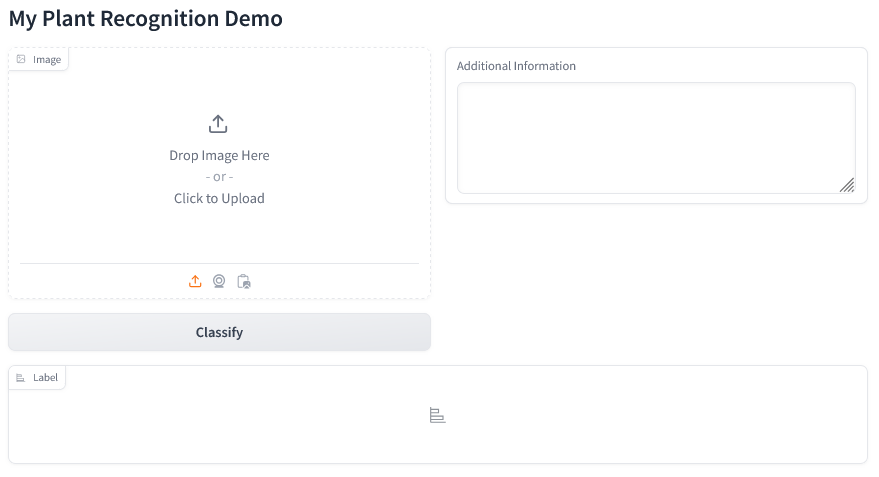

Let's draw it out. Be aware that:
- `gr.Image` will create an input element for images
- `gr.Button()` will create a button element
- `gr.Textbox()` will create a place for text to go
- `gr.Label()` will create the a place that outputs our categories and probabilities as before

**So what happens when the button with the words 'Classify' is clicked?**

## Classifying and Displaying Predictions and Additional Information

`classify_btn.click(fn=classify_and_display, inputs=image, outputs=[label, additional_info])`

When clicked, the a function called `classify_and_display()` is triggered.

`classify_and_display()` takes an input of an image, so it actually really looks more like `classify_and_display(img)`, and it returns a list containing 2 things. The first thing in the list that it returns is the 'label' (like we had earlier) and some data that will be called 'additional_info'.

The code for this function is in the following code cell.

In [ ]:
def classify_and_display(img):
    result = classify_image(img)
    predicted_result = result["predicted_category"]
    additional_info = get_additional_info(predicted_result)
    return result["probabilities"], additional_info

It looks like classify and display gives us a few pieces of information. It returns both `result['probabilities']` and `additional_info`, in that order.

Looking back at the code that calls `classify_and_display(img)` we can see that these return values go to certain places in the user interface.  
`classify_btn.click(fn=classify_and_display, inputs=image, outputs=[label, additional_info])`
- `result['probabilities']` will put the information in the `label = gr.Label()` element.
- `additional_info` will put the information in the `additional_info = gr.Textbox(label="Additional Information", lines=5, interactive=False)` element.

**So where do the values for the variables `result['probabilities']` and `additional_info` come from?**

## Classifying an Image

`result` is set by the function `classify_image(img)` function (not `classify_and_display(img)`).  
`result = classify_image(img)`

But, that's not just `result['probabilities']`.

`classify_image(img)` returns 2 things, a dictionary that has `{predicted_category, probabilities}`, shown in the code below.

In [ ]:
def classify_image(img):
    img = PILImage.create(img).resize((192, 192))
    pred, idx, probs = learn.predict(img)
    predicted_category = original_categories[idx]
    return {
        "predicted_category": predicted_category,
        "probabilities": dict(zip(categories, map(float, probs)))
    }

This is very similar to the first function we used to just output a label, but here we are setting aside the category with the highest probability of being correct and not the full list of all categories with probabilities.

**Is this predicted category always correct?**

## Getting Additional Information from a Prediction

So now that we know where the predicted category comes from, and the dictionary of probabilities, where do we get the additional info from? We don't just want to output a bunch of words.

As we discovered earlier, this information is stored in a variable called `addtional_info` and is set by a function called `additional_info()` that has the input of the `predicted_result` returned by `classify_image(img)`.

`predicted_result = result["predicted_category"]`  
`additional_info = get_additional_info(predicted_result)`

The code for the `additional_info(predicted_result)` function is in the following code cell.

In [ ]:
def get_additional_info(predicted_category):
    if predicted_category in name_map.keys():
        return f"Lakota: {name_map[predicted_category]['Lakota']}\nDescription: {name_map[predicted_category]['desc']}\n"
    else:
        return "No additional information available."

I looks like the `get_additional_info(predicted_category)` function utilizes a variable called `map_keys`, which is a dictionary that we can use to translate the single label we get from our model to much more information.

Basically, we can go from:  
`label = 'prairie_turnip'`  
to  
`name_map = {'prairie_turnip': {`  
`                                  'Lakota': 'timpsila',`  
`                                  'Description': 'Timpsila is an excellent source of nutrients.'`  
`                              }`  
`       }`

***IMPORTANT***  
In the `get_additional_info(predicted_category)` function above, the return must match the values in the `name_map` variable.  
So that sending the function the string 'prairie_turnip' returns values that match to `name_map['prairie_turnip']['Lakota']` and `name_map['prairie_turnip']['desc']`.  

**In the next code cell, set up a name map for your labels. What additional information should be presented in your application?**

In [1]:
name_map = {
            "Yucca": {
                "Lakota": "Hupȟéstola",  
                "desc": "description"
            },
            "Prairie_Turnip": {
                "Lakota": "Timspila",                 
                "desc": "description"
            },
            "Juniper": {
                "Lakota": "Hanté",  
                "desc": "description"
            },
            "Spruce": {
                "Lakota": "wazíȟčaka",  
                "desc": "description"
            },
            "Flax": {
                "Lakota": "Haȟúntahu",  
                "desc": "description"
            },
            "Plantain": {
                "Lakota": "Wihúta-hú-iyéčhata",  
                "desc": "description"
            }
           }

def get_additional_info(predicted_category):
    if predicted_category in name_map.keys():
        return f"Lakota: {name_map[predicted_category]['Lakota']}\nDescription: {name_map[predicted_category]['desc']}"
    else:
        return "No additional information available."

Now run the cell above and use the cell below to test it. Be sure to modify any of the keys that you changed from the key's used above.

Notes:
- the `'\n'` will create a new line
- The keys are things like `'Lakota'` and `'desc'`

In [2]:
print(get_additional_info('dino'))

'Lakota: Wihúta-hú-iyéčhata\nDescription: description'

And the final step to wrap up the explanation of the code is that we need to create a new category list using the Lakota language.  

We accomplish that using the following code.

In [ ]:
# set aside our original categories because we're going to need them in a function below
original_categories = categories

name_map = {
            # all your data from above would go here.
           }

# create a space to hold remapped categores
new_categories = []

# for each element in our model's categories, make a new element that is "Lakota name (English name)"
# if there isn't a Lakota name in our name_map, just keep the English name
for category in categories:
    if category in name_map.keys():
        new_categories.append(name_map[category]['Lakota'] + f" ({category})")
    else:
        new_categories.append(category)
        print(category)

# replace the categories from our model with our "Lakota name (English name)" categories
# don't forget that we still have those original categories in the variable "original categories"
categories = new_categories

## Tying it all together

The code cell below is what your code should look like, except for your `name_map` dictionary and the specifics of the `get_additional_info(predicted_category)` output.  

You can copy and paste if you need, but please read through the comments to try to understand what is going on.

In [ ]:
from fastai.vision.all import *
# import timm
import gradio as gr

path_to_pkl_model = 'YOUR_MODEL_FILENAME.pkl'

learn = load_learner(path_to_pkl_model)

# get our categories from our model
categories = learn.dls.vocab

# set aside our original categories because we're going to need them in a function below
original_categories = categories

# the name_map variable let's use use our original, one word, categories and attach more information to those values
# we use this information to put Lakota into the output and any other things we want to have
# NOTE: IF YOU WANT TO ADD MORE ELEMENTS, YOU WILL NEED MODIFY THE get_additional_info function
name_map = {
            "Yucca": {
                "Lakota": "Hupȟéstola",  
                "desc": "description"
            },
            "Prairie_Turnip": {
                "Lakota": "Timspila",                 
                "desc": "description"
            },
            "Prairie_Turnip_Root": {
                "Lakota": "Timpsila",                    
                "desc": "description"
            },
            "Juniper": {
                "Lakota": "Hanté",  
                "desc": "description"
            },
            "Poison_Hemlock": {
                "Lakota": "Yažópi-hú",  
                "desc": "description"
            },
            "Spruce": {
                "Lakota": "wazíȟčaka",  
                "desc": "description"
            },
            "Flax": {
                "Lakota": "Haȟúntahu",  
                "desc": "description"
            },
            "Plantain": {
                "Lakota": "Wihúta-hú-iyéčhata",  
                "desc": "description"
            },
            "Scarlet_Guara": {
                "Lakota": "tȟatȟáwabluška",  
                "desc": "description"
            },
            "Stone_Seed": {
                "Lakota": "sunkačanka huipiye",  
                "desc": "description"
            },
            "Juneberry": {
                "Lakota": "wípazutkȟaŋ",  
                "desc": "description"
            },
            "Wild_Rose_Bush": {
                "Lakota": "uŋžíŋžiŋtka hú",  
                "desc": "description"
            },
            "Red_Willow": {
                "Lakota": "čhaŋšáša",  
                "desc": "description"
            },
            "Cow_Parsnip": {
                "Lakota": "pangi tȟáŋka",  
                "desc": "description"
            },
            "Harebell": {
                "Lakota": "waȟpé tȟó",  
                "desc": "description"
            },
            "Yarrow": {
                "Lakota": "tȟaópi pȟežúta",  
                "desc": "description"
            },
            "Silver_Leaf_Scurfpea": {
                "Lakota": "matȟó tȟathíŋpsila",  
                "desc": "description"
            },
            "Poison_Ivy": {
                "Lakota": "wikȟóška pȟežúta",  
                "desc": "description"
            },
            "Burr_Oak_Tree": {
                "Lakota": "útahu čháŋ",  
                "desc": "description"
            },
            "Sochan": {
                "Lakota": "wahpe zizicha sake",  
                "desc": "description"
            },
            "Sego_Lily": {
                "Lakota": "pšíŋ tȟáŋka",  
                "desc": "description"
            },
            "Box_Elder_Mushroom": {
                "Lakota": "čhaŋnákpa",  
                "desc": "description"
            },
            "Box_Elder_Maple_Tree": {
                "Lakota": "čhaŋšúška",  
                "desc": "description"
            },
            "Pine_Tree": {
                "Lakota": "wazí čháŋ",  
                "desc": "description"
            },
            "Chokecherry": {
                "Lakota": "čhaŋpȟá",  
                "desc": "description"
            },
            "Smooth_Brome": {
                "Lakota": "pezhi wasicun",  
                "desc": "description"
            },
            "Burdock": {
                "Lakota": "waȟpé tȟáŋka",  
                "desc": "description"
            },
            "Yellow_Sweet_Clover": {
                "Lakota": "waȟpé swúla",  
                "desc": "description"
            },
            "Goatsbeard": {
                "Lakota": "waȟčá zí iyéčheča",  
                "desc": "description"
            },
            "Dog_Bane": {
                "Lakota": "napéoilekiyapi",  
                "desc": "description"
            },
            "Black_Hills_Spruce": {
                "Lakota": "wazíȟčaka",  
                "desc": "description"
            },
            "Raspberry_Shrub": {
                "Lakota": "tȟakȟáŋhečala hú",  
                "desc": "description"
            }
           }


# create a space to hold remapped categores
new_categories = []

# for each element in our model's categories, make a new element that is "Lakota name (English name)"
# if there isn't a Lakota name in our name_map, just keep the English name
for category in categories:
    if category in name_map.keys():
        new_categories.append(name_map[category]['Lakota'] + f" ({category})")
    else:
        new_categories.append(category)
        print(category)

# replace the categories from our model with our "Lakota name (English name)" categories
# don't forget that we still have those original categories in the variable "original categories"
categories = new_categories

# from the paramenter "predicted category", use the name_map dictionary to create text of more information for that category
def get_additional_info(predicted_category):
    if predicted_category in name_map.keys():
        return f"Lakota: {name_map[predicted_category]['Lakota']}\nDescription: {name_map[predicted_category]['desc']}\n"
    else:
        return "No additional information available."

# from the parameter "img", make a prediction on what category that img is most likely to be according to our model
# this will return a list that includes 1. "predicted_category" and 2. "probabilities", this is just returning data
# we need the probabilities to create content to show the Label
# we need the predicted_category to create content for the Additional Information textbox
def classify_image(img):
    img = PILImage.create(img).resize((192, 192))
    pred, idx, probs = learn.predict(img)
    predicted_category = original_categories[idx]
    return {
        "predicted_category": predicted_category,
        "probabilities": dict(zip(categories, map(float, probs)))
    }

# from the parameter "img", both classify the image and create the additional information for the most likely category
# returns what will go in the label and text boxes and makes the data human readable
def classify_and_display(img):
    result = classify_image(img)
    predicted_result = result["predicted_category"]
    additional_info = get_additional_info(predicted_result)
    return result["probabilities"], additional_info

with gr.Blocks() as demo: #sets a space on the page that will be launched as demo
    gr.Markdown("# My Plant Recognition Demo") # creates a title type text on the page
    with gr.Row(): # creates a row
        with gr.Column(): # in the row above, creates a column
            image = gr.Image() # places an image element in this column, this is where we collect the image
            classify_btn = gr.Button("Classify") # places a button element in the column that triggers classification
        with gr.Column(): # in the row above, creates a new column
            additional_info = gr.Textbox(label="Additional Information", lines=5, interactive=False) # creates a textbox for the additional info
            #gr.Label("Output")
    with gr.Row(): # create a new row
        label = gr.Label() # creat a label element where our classification probabilities will be placed
    
    # the code below is for a "click" event on the classify_button element we placed above
    # this code runs the function classify_and_display, sends that function an image from the image elemement
    # classify_and_display returns the content for the label and additional_info elements, and outputs sends that data to those elements
    classify_btn.click(fn=classify_and_display, inputs=image, outputs=[label, additional_info])

# launch the page    
demo.launch(inline=False)